In [ ]:
# Author: aarontanx
# Cases and Vaccination Prediction

In [313]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import KFold
from matplotlib.pyplot import figure

In [280]:
print('Last update:', datetime.datetime.now())

Last update: 2021-09-10 11:33:51.445508


In [281]:
df_Case_My = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv')
df_Vac_My = pd.read_csv('https://raw.githubusercontent.com/CITF-Malaysia/citf-public/main/vaccination/vax_malaysia.csv')

In [282]:
df_Case_My.head()

,date,cases_new,cases_import,cases_recovered,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
df_Vac_My.head()

,date,daily_partial,daily_full,daily,cumul_partial,cumul_full,cumul,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,60,0,60,60,0,0,0,0,0,0,0
1,2021-02-25,1145,0,1145,1205,0,1205,1145,0,0,0,0,0,0,0
2,2021-02-26,4096,0,4096,5301,0,5301,4096,0,0,0,0,0,0,0
3,2021-02-27,6716,0,6716,12017,0,12017,6716,0,0,0,0,0,0,0
4,2021-02-28,6701,3,6704,18718,3,18721,6701,3,0,0,0,0,0,0


In [284]:
dfVacCase = df_Case_My.merge(df_Vac_My, on=['date'])

In [285]:
dfVacCase.columns

Index(['date', 'cases_new', 'cases_import', 'cases_recovered',
       'cluster_import', 'cluster_religious', 'cluster_community',
       'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre',
       'cluster_workplace', 'daily_partial', 'daily_full', 'daily',
       'cumul_partial', 'cumul_full', 'cumul', 'pfizer1', 'pfizer2',
       'sinovac1', 'sinovac2', 'astra1', 'astra2', 'cansino', 'pending'],
      dtype='object')

In [286]:
dfVacCase.rename(columns={'daily':'daily_vaccination_count'}, inplace=True)

In [287]:
dailyNewCase = dfVacCase[['date', 'cases_new', 'cases_recovered', 'daily_vaccination_count']]

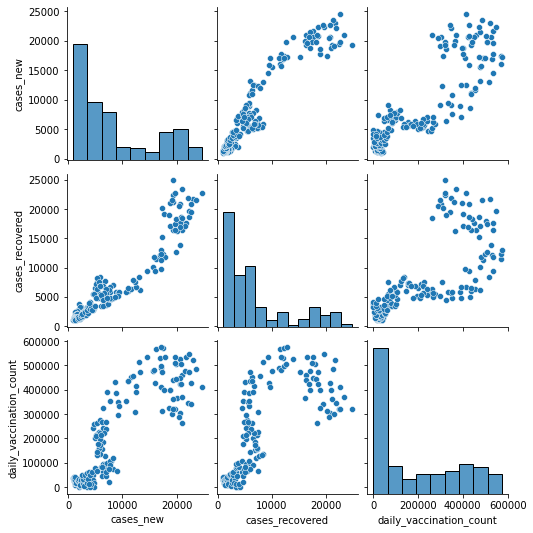

In [288]:
sns.pairplot(dailyNewCase)

In [289]:
dfVacCase['date'] = pd.to_datetime(dfVacCase['date'])
dfVacCase['days_since'] = (dfVacCase['date'] - dfVacCase['date'].min())  / np.timedelta64(1,'D')

In [290]:
dfVacCase[['days_since', 'daily_vaccination_count']]

,days_since,daily_vaccination_count
0,0.0,60
1,1.0,1145
2,2.0,4096
3,3.0,6716
4,4.0,6704
...,...,...
193,193.0,289958
194,194.0,313751
195,195.0,326476
196,196.0,320452


In [314]:
# Regression vaccination count
def regression(X, y, model='linear', alpha=0.5, max_iter=100):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    if model == 'ridge':
        model = Ridge(alpha=alpha)
    elif model == 'bayesian':
        model = BayesianRidge()
    elif model == 'svm':
        model = SVR()
    elif model == 'lasso':
        model = Lasso()
    elif model == 'logistic':
        model = LogisticRegression(max_iter = max_iter)
    else: model = LinearRegression()

    scores = []
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    for i, (train, test) in enumerate(kfold.split(X, y)):
        model.fit(X.iloc[train,:], y.iloc[train,:])
        score = model.score(X.iloc[test,:], y.iloc[test,:])
        scores.append(score)
#     print(scores)
    return(model)

In [321]:
# Regress daily vaccination count

model = 'linear'
dfCurrent = dfVacCase[['days_since', 'date', 'cases_new', 'daily_vaccination_count']].copy()
dfCurrent['status'] = 'current'

forecastDays100 = [i for i in dfVacCase['days_since'].max()+range(100)]
forecastDate100 = [dfVacCase['date'].max() + datetime.timedelta(days=x) for x in range(100)]

dfPredict = pd.DataFrame()
dfPredict['days_since'] = pd.Series(forecastDays100)
dfPredict['date'] = pd.Series(forecastDate100)
X = dfVacCase['days_since']
y = dfVacCase['daily_vaccination_count']
result = regression(X, y, model = model, alpha = 1e-8)
x = dfPredict['days_since']
predictionResult = result.predict(x.values.reshape(-1, 1)).reshape(-1).tolist()

# Forecast daily vaccination count
dfPredict['daily_vaccination_count'] = pd.Series(predictionResult)

X = dfVacCase[['days_since', 'daily_vaccination_count']]
y = dfVacCase['cases_new']
result = regression(X, y, model= model, alpha = 1e-8)

# dfPredict['daily_vaccination_count'] = pd.Series(regression(X, y, model='ridge', alpha = 0.1))
x1 = dfPredict[['days_since', 'daily_vaccination_count']]

predictionResult = result.predict(np.array(x1)).reshape(-1).tolist()
dfPredict['cases_new'] = pd.Series(predictionResult).apply(lambda x: round(x, 0))
dfPredict['status'] = 'prediction'

dfCombined = dfCurrent.append(dfPredict)

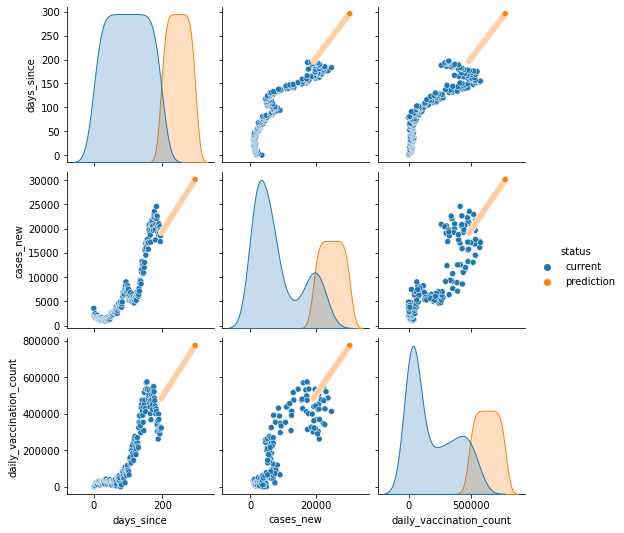

In [322]:
sns.pairplot(dfCombined, hue='status')

<AxesSubplot:xlabel='date', ylabel='daily_vaccination_count'>

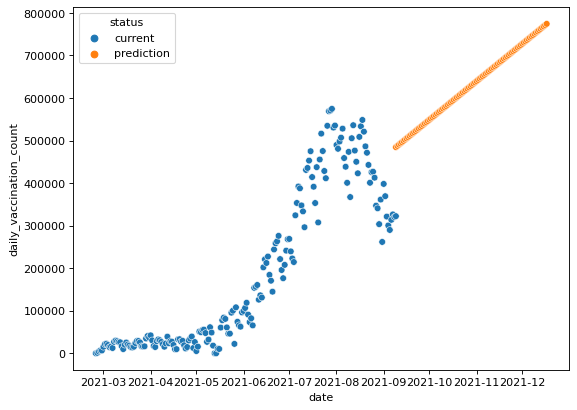

In [323]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data = dfCombined, x = 'date', y='daily_vaccination_count', hue='status')

<AxesSubplot:xlabel='date', ylabel='cases_new'>

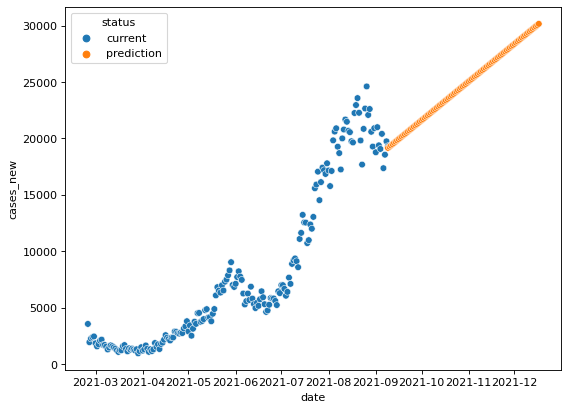

In [324]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data = dfCombined, x = 'date', y='cases_new', hue='status')